In [16]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.manifold import TSNE
import seaborn as sns


(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.


noise_factor = 0.4
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)
x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)
x_train_noisy = np.expand_dims(x_train_noisy, -1)
x_test_noisy = np.expand_dims(x_test_noisy, -1)

input_img = tf.keras.Input(shape=(28, 28, 1))

# Encoder
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(x)
encoded = layers.MaxPooling2D((2, 2), padding='same', name="bottleneck")(x)

# Decoder
x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(encoded)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
decoded = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

# Autoencoder model
autoencoder = models.Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

# Early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the autoencoder
history = autoencoder.fit(x_train_noisy, x_train,
                epochs=50,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test_noisy, x_test),
                callbacks=[early_stop])

Epoch 1/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 0.4036 - val_loss: 0.3072
Epoch 2/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.3031 - val_loss: 0.2993
Epoch 3/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.2961 - val_loss: 0.2960
Epoch 4/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.2931 - val_loss: 0.2940
Epoch 5/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.2913 - val_loss: 0.2927
Epoch 6/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.2905 - val_loss: 0.2915
Epoch 7/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.2891 - val_loss: 0.2906
Epoch 8/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.2879 - val_loss: 0.2901
Epoch 9/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.2878 - val_loss: 0.2896
Epoch 10/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.2878 - val_loss: 0.2889
Epoch 11/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.2865 - val_loss: 0.2891
Epoch 12/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step

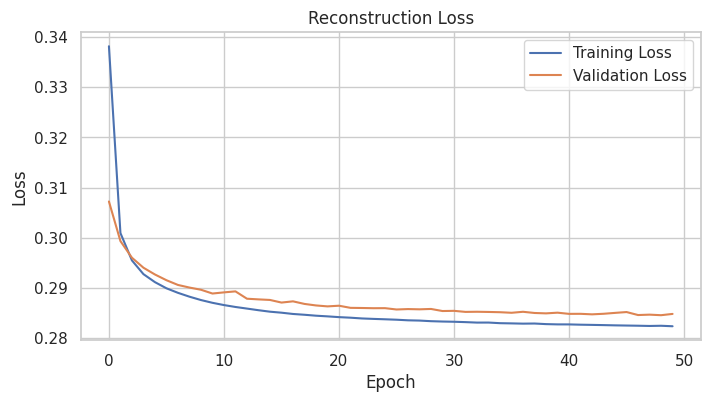

In [17]:
# Plot loss curves
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Reconstruction Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


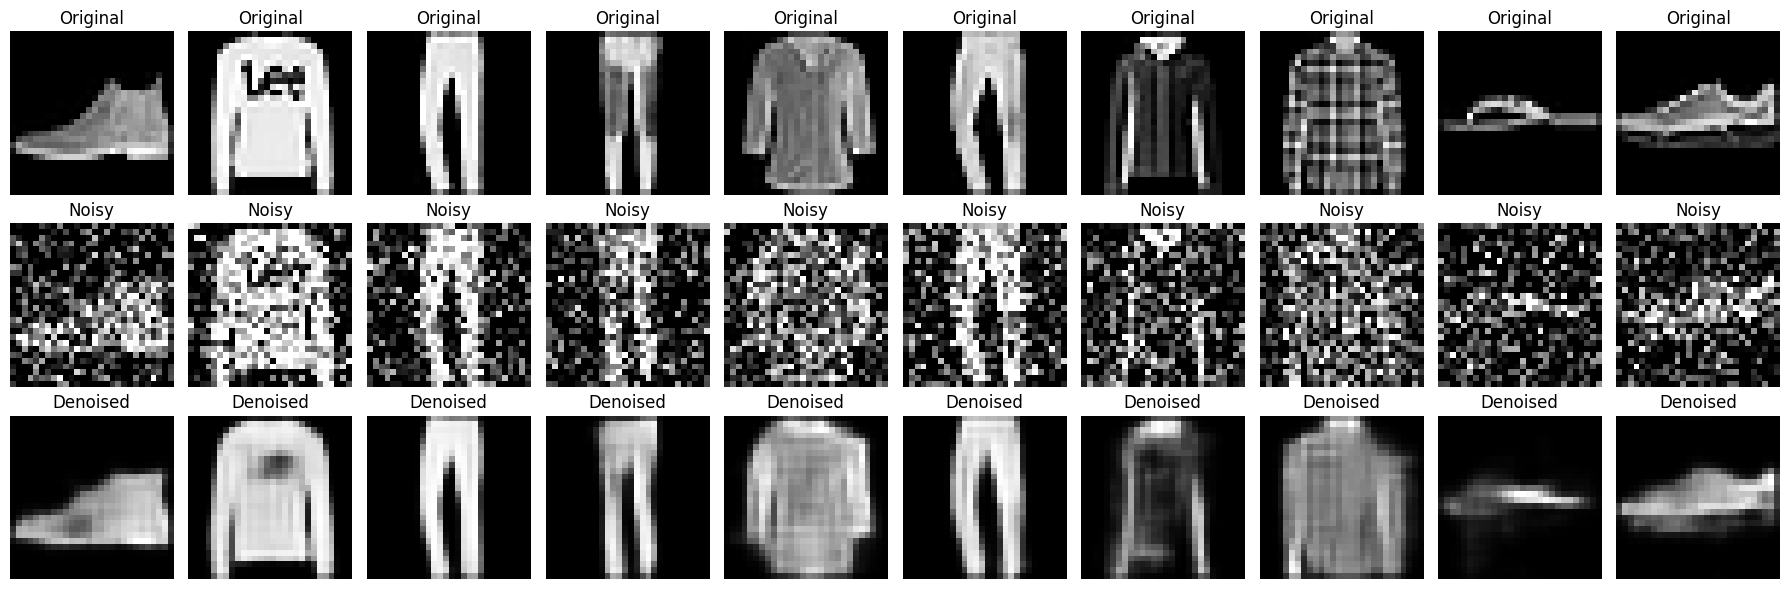

In [13]:
# Reconstruct images
decoded_imgs = autoencoder.predict(x_test_noisy)

# Visualize original, noisy, and denoised
n = 10
plt.figure(figsize=(18, 6))
for i in range(n):
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28), cmap='gray')
    plt.title("Original")
    plt.axis("off")

    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(x_test_noisy[i].reshape(28, 28), cmap='gray')
    plt.title("Noisy")
    plt.axis("off")

    ax = plt.subplot(3, n, i + 1 + 2 * n)
    plt.imshow(decoded_imgs[i].reshape(28, 28), cmap='gray')
    plt.title("Denoised")
    plt.axis("off")
plt.tight_layout()
plt.show()

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step


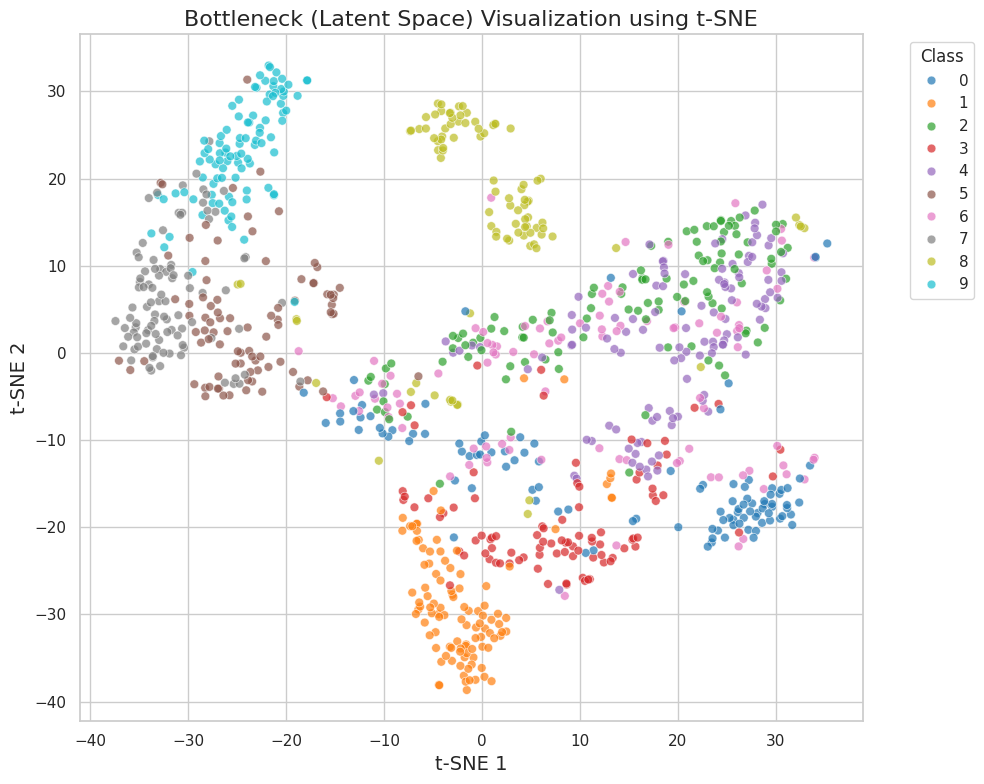

In [14]:
# Extract bottleneck model
encoder = models.Model(inputs=autoencoder.input, outputs=autoencoder.get_layer("bottleneck").output)

# Get encoded (bottleneck) features
encoded_imgs = encoder.predict(x_test_noisy[:1000])  # use 1000 samples
encoded_flat = encoded_imgs.reshape(1000, -1)         # flatten for t-SNE

# Apply t-SNE
sns.set(style="whitegrid")
tsne = TSNE(n_components=2, random_state=42)
tsne_result = tsne.fit_transform(encoded_flat)

# Plot t-SNE result
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x=tsne_result[:, 0],
    y=tsne_result[:, 1],
    hue=y_test[:1000],
    palette='tab10',
    legend='full',
    s=40,
    alpha=0.7
)
plt.title('Bottleneck (Latent Space) Visualization using t-SNE', fontsize=16)
plt.xlabel('t-SNE 1', fontsize=14)
plt.ylabel('t-SNE 2', fontsize=14)
plt.legend(title='Class', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
Bottleneck feature shape: (1, 7, 7, 16)


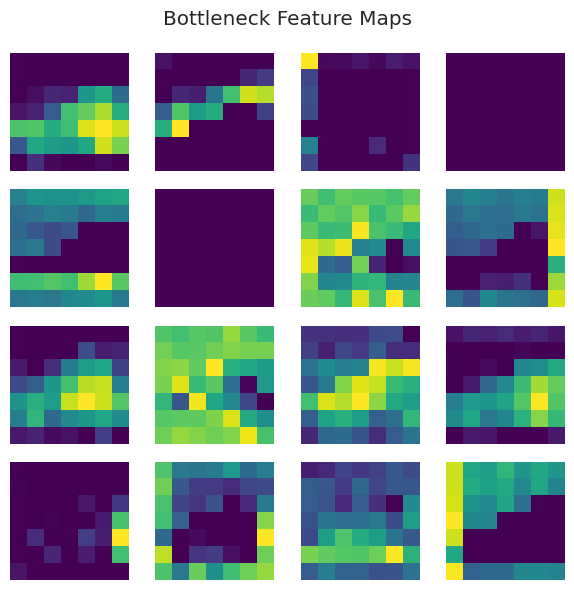

In [15]:
# Extract bottleneck model
bottleneck_model = models.Model(inputs=autoencoder.input, outputs=autoencoder.get_layer("bottleneck").output)

# Get bottleneck features
features = bottleneck_model.predict(x_test_noisy[:1])

print("Bottleneck feature shape:", features.shape)

# Show feature maps from bottleneck layer
fig, axes = plt.subplots(4, 4, figsize=(6,6))
for i, ax in enumerate(axes.flat):
    ax.imshow(features[0, :, :, i], cmap='viridis')
    ax.axis('off')
plt.suptitle("Bottleneck Feature Maps")
plt.tight_layout()
plt.show()

**summary:**

This code implements a Denoising Convolutional Autoencoder on the Fashion MNIST dataset:

Adds noise to images and trains an autoencoder to reconstruct clean images.

Uses convolutional layers for encoding and decoding.

Applies early stopping to prevent overfitting.

Visualizes original, noisy, and denoised images.

Extracts bottleneck (latent) features from the encoder.

Uses t-SNE to reduce bottleneck features to 2D and visualizes class separation in the latent space.

